<a href="https://colab.research.google.com/github/FrederikKnudsen/Fastpage/blob/master/FastPage/_notebooks/2021_04_27_Hotdog_Classifier-Callback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotdog Classifier

Opsætning af FastAI

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.7MB/s 
     |████████████████████████████████| 194kB 19.4MB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 1.2MB 25.3MB/s 
     |████████████████████████████████| 12.8MB 221kB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
# Azure API Key
key = os.environ.get('AZURE_SEARCH_KEY', '88f816fb74d147e08b211baf0cceebbb')

In [ ]:
bear_types = 'hotdog', 'random'
path = Path('hotdogs')

In [ ]:
# Looper over de specificerede typer og søger på dem hver især
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# Tjekker om der er billeder som er failed 
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#8) [Path('hotdogs/random/00000138.png'),Path('hotdogs/random/00000073.jpg'),Path('hotdogs/random/00000080.jpg'),Path('hotdogs/hotdog/00000099.png'),Path('hotdogs/hotdog/00000014.jpg'),Path('hotdogs/hotdog/00000045.jpg'),Path('hotdogs/hotdog/00000007.jpg'),Path('hotdogs/hotdog/00000050.jpeg')]

In [ ]:
# Fjerner billeder som er failed
failed.map(Path.unlink);

In [ ]:
# Laver DataLoaders for datasettet vi lige har downloaded udfra følgende:
# What kinds of data we are working with
# How to get the list of items
# How to label these items
# How to create the validation set

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
# Fortæller FastAI hvor kilden af dataen kan findes
dls = bears.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


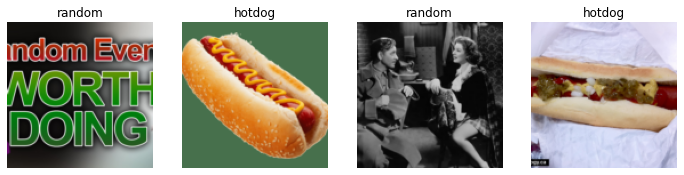

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# Callback function
validLossList = []
class PrintLoss(Callback):
    def after_epoch(self):
      validLossList.append(self.learn.loss)
      if len(validLossList) >= 2:
        if validLossList[-2] > validLossList[-1]:
          self.learn.lr_find()
          print(self.learn.recorder.min_grad_lr)
          # self.learn.pred = learn.recorder.min_grad_lr
          # learn.lr_find(stop_div=False, num_it=200)
          # print(learn.recorder.plot(suggestion=True))
        return True

In [ ]:
# Træning af modellen
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fit(3, cbs=PrintLoss())

epoch,train_loss,valid_loss,error_rate,time
0,0.710942,2.795571,0.566038,00:12


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


KeyboardInterrupt: ignored

In [ ]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Data cleaning
cleaner = ImageClassifierCleaner(learn)

Eksportering af trænet model

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

APP

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your hotdog!'), 
      btn_upload, btn_run, out_pl, lbl_pred])